In [1]:
# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Keras
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, scale, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D, Input
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l1
from keras.utils.vis_utils import plot_model
from datetime import datetime
from sklearn import metrics
import librosa, librosa.display, os, csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pylab
plt.switch_backend('agg')
import itertools
import scipy as sp
from scipy import signal
import xgboost as xgb
import joblib
from glob import glob
import urllib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Basic Libraries

import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler

## Extracting the Spectrogram for every Audio File

In [2]:
#Loading CSV file
train_csv = pd.read_csv("../input/coughclassifier-trial/cough_trial_extended.csv")
dataset = "../input/coughclassifier-trial/cough_trial_extended.csv"
train_csv

,file_properties,class
0,0v8MGxNetjg_ 10.000_ 20.000.wav,not_covid
1,1j1duoxdxBg_ 70.000_ 80.000.wav,not_covid
2,1MSYO4wgiag_ 120.000_ 130.000.wav,not_covid
3,1PajbAKd8Kg_ 0.000_ 10.000.wav,not_covid
4,cov1.wav,covid
...,...,...
165,-bZrDCS8KAg_ 70.000_ 80.000.wav,not_covid
166,-ej81N6Aqo4_ 0.000_ 8.000.wav,not_covid
167,-gvLnl1smfs_ 90.000_ 100.000.wav,not_covid
168,-hu5q-Nn4BM_ 70.000_ 80.000.wav,not_covid


In [3]:
train_csv['class'].unique()

array(['not_covid', 'covid'], dtype=object)

In [4]:
cmap = plt.get_cmap('inferno')
tot_rows = train_csv.shape[0]
for i in range(tot_rows):
    source = train_csv['file_properties'][i]
    filename = '../input/coughclassifier-trial/trial_covid/'+source
    y,sr = librosa.load(filename, mono=True, duration=5)
    plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
    plt.axis('off');
    plt.savefig(f'./{source[:-3].replace(".", "")}.png')
    plt.clf()

<Figure size 432x288 with 0 Axes>

All the audio files get converted into their respective spectrograms .We can know easily extract features from them.

## Extracting features from Spectrogram


We will extract

* Mel-frequency cepstral coefficients (MFCC)(20 in number)
* Spectral Centroid,
* Zero Crossing Rate
* Chroma Frequencies
* Spectral Roll-off.

In [5]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

## Writing data to csv file

We write the data to a csv file

In [6]:
file = open('data_new_extended.csv', 'w')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
for i in range(tot_rows):
        source = train_csv['file_properties'][i]
        file_name = '../input/coughclassifier-trial/trial_covid/'+source
        y,sr = librosa.load(file_name, mono=True, duration=5)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{source[:-3].replace(".", "")} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        
        file = open('data_new_extended.csv', 'a')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

# Analysing the Data in Pandas

In [7]:
data = pd.read_csv('../input/coughclassifier-trial/data_new_extended.csv')
data

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0v8MGxNetjg_,0.519951,0.045853,1612.895795,1411.838677,2907.580566,0.107019,-376.876007,111.017372,-31.904015,...,-7.439712,-1.034580,-0.203084,-3.513495,-1.745704,-3.011878,-2.878482,-2.106427,-4.026825,not_covid
1,1j1duoxdxBg_,0.535472,0.001771,2892.087076,2467.408141,5072.664388,0.148584,-519.158447,60.781284,-13.722884,...,-0.909972,7.216461,-1.719630,3.903021,3.653039,3.043882,2.439958,2.781968,2.195162,not_covid
2,1MSYO4wgiag_,0.496666,0.033657,3429.061935,2788.634413,6886.288452,0.225315,-282.297913,48.581680,-15.522367,...,-6.066336,-4.167640,1.017302,-0.523806,0.538693,-8.855953,-2.927977,-1.118562,-5.906227,not_covid
3,1PajbAKd8Kg_,0.407549,0.013452,2710.811637,2664.287550,5778.474935,0.142076,-346.857300,75.765617,-7.648193,...,5.053118,-0.291308,0.987186,-2.447526,3.692367,2.312328,-2.059656,-4.772599,-0.503851,not_covid
4,cov1,0.412697,0.059004,1555.648634,1418.599932,2870.737092,0.133998,-340.588013,104.156700,-32.228443,...,-8.247169,0.940006,-5.701087,-6.326630,-1.080040,-1.812609,-2.518986,-3.684266,-3.564146,covid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,#NAME?,0.492974,0.005093,1600.647469,2300.999728,3660.644531,0.047815,-543.776916,119.100296,23.902969,...,-1.250754,-2.634280,1.647435,0.647164,1.602689,-2.469729,0.704325,-5.352920,-1.281080,not_covid
166,#NAME?,0.400283,0.052132,2664.129566,2563.440387,5518.182373,0.121514,-290.840607,85.514412,-10.986873,...,-4.629812,-7.424622,-4.511141,-7.482200,-4.865530,-6.353733,-5.024187,-8.422812,-0.831208,not_covid
167,#NAME?,0.704281,0.058739,3090.031219,2740.856272,6530.841064,0.179077,-75.595451,68.849228,-11.665833,...,0.677697,-7.535110,0.602187,-6.629556,0.659050,-4.125256,0.734950,-4.655417,-0.645009,not_covid
168,#NAME?,0.424896,0.044159,3173.872023,2482.951387,5768.306478,0.221743,-264.064514,58.729767,-7.446329,...,-0.625627,0.677355,-3.651989,-6.051375,1.211774,-14.923816,-11.180058,-8.861262,-5.078876,not_covid


In [8]:
data.shape

(170, 28)

In [9]:
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)

## Encoding the Labels

In [10]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

## Scaling the Feature columns

In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

## Dividing data into training and Testing set

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [13]:
X_train.shape

(113, 26)

In [14]:
X_train.shape[1]

26

In [15]:
y_train.shape

(113,)

# Classification with Keras

## Building our Network

Saved model to disk


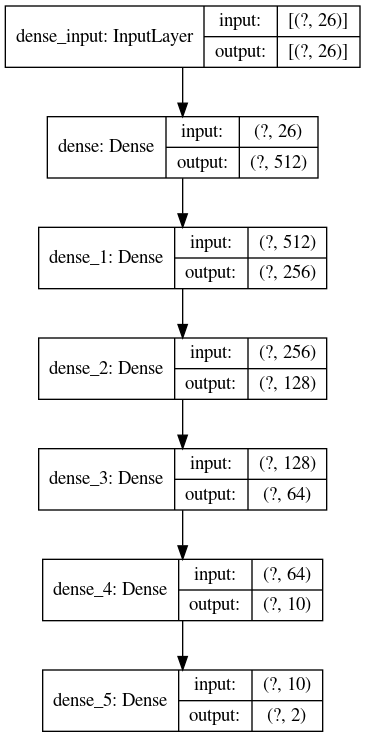

In [16]:

from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))

model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(10, activation='relu'))

model.add(layers.Dense(2, activation='softmax'))

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# plot model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               13824     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 22        
Total params: 186,976
Trainable params: 186,976
Non-trainable params: 0
__________________________________________________

In [18]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=128)

Epoch 1/100
1/1 [==============================] - 0s 4ms/step - loss: 0.7398 - accuracy: 0.1681
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.6211 - accuracy: 0.9027
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.5332 - accuracy: 0.9027
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 0.4517 - accuracy: 0.9027
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3788 - accuracy: 0.9027
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3200 - accuracy: 0.9027
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2777 - accuracy: 0.9027
Epoch 8/100
1/1 [==============================] - 0s 1ms/step - loss: 0.2490 - accuracy: 0.9027
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2282 - accuracy: 0.9027
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2100 - accuracy: 0.9027
Epoch 11/100
1/1 [===========

In [19]:
test_loss, test_acc = model.evaluate(X_test,y_test)

2/2 [==============================] - 0s 3ms/step - loss: 0.0928 - accuracy: 0.9649


In [20]:
model.save('cough_sound_classifier.h5')

In [21]:
from tensorflow import keras
model = keras.models.load_model('./cough_sound_classifier.h5')

In [22]:
model

### Test Accuracy

In [23]:
print('test_acc: ',test_acc)

test_acc:  0.9649122953414917


## Predictions on Test Data

In [24]:
test = X_test[6]
test = np.expand_dims(test, axis=0)

In [25]:
predictions = model.predict(test)
print(predictions[0].shape)
print(np.sum(predictions[0]))
print(predictions[:4])
print(y_test[:4])

(2,)
1.0
[[4.6893065e-14 1.0000000e+00]]
[1 1 1 1]


In [26]:
predictions[0][0]

4.6893065e-14

In [27]:
np.argmax(predictions)

1

In [28]:
y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1])

## Saving the Spectograms as a single output file

In [29]:
!tar -zcvf outputname.tar.zip /kaggle/working

tar: Removing leading `/' from member names
/kaggle/working/
/kaggle/working/-vu4jJkffMw_ 80000_ 90000.png
/kaggle/working/39IZIbmQPzA_ 40000_ 50000.png
/kaggle/working/7QkwmMU4w1M_ 220000_ 230000.png
/kaggle/working/4rPNHAf-0Qw_ 30000_ 40000.png
/kaggle/working/cough-heavy-QjBZv868nydJzk0ZzwgKDHSG6Q82.png
/kaggle/working/_D3sxdtbFas_ 40000_ 50000.png
/kaggle/working/3bas_0f3RG0_ 50000_ 60000.png
/kaggle/working/2R3J8pH6E6s_ 20000_ 30000.png
/kaggle/working/-jLQkyDhIxw_ 10000_ 20000.png
/kaggle/working/1PajbAKd8Kg_ 0000_ 10000.png
/kaggle/working/9WNz_rrwLFE_ 20000_ 30000.png
/kaggle/working/2B_QV_5R4Zo_ 10000_ 20000.png
/kaggle/working/6uW93XzK0Xw_ 0000_ 10000.png
/kaggle/working/0mZQ6Q-viPw_ 10000_ 20000.png
/kaggle/working/_9YKlnmoDjs_ 11000_ 21000.png
/kaggle/working/9P8waFCqbOQ_ 90000_ 100000.png
/kaggle/working/9pX8I7KzQAI_ 10000_ 20000.png
/kaggle/working/--U7joUcTCo_ 0000_ 10000.png
/kaggle/working/44nJyshuBYk_ 20000_ 30000.png
/kaggle/working/-VbTE2bPuyw_ 210000_ 220000.png
/k